In [1]:
import sys

print(sys.version)

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [2]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    multiply,
    concatenate,
)
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# import numpy as np

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

# from IPython import display

In [4]:
print("Tensorflow version: ", tf.VERSION)  # 1.13.1
print("Keras version: ", tf.keras.__version__)  # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

# from tensorflow.python.client import device_lib
# print('List of GPUs:\n',
#       [x for x in device_lib.list_local_devices()
#        if x.device_type == "GPU" or x.device_type == "SYCL"])

Tensorflow version:  1.14.0
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  True


# SmallerVGGNet, with noise layer added

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [5]:
filename = "input_noise"

path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

predict_only = True
predict_test_only = True

In [6]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # add black & white noise to input data
        if chanDim == -1:
            noiseShape = (height, width, 1)
        else:
            noiseShape = (1, height, width)

        model.add(Dropout(0.2, noise_shape=noiseShape, input_shape=inputShape))  # black
        model.add(Lambda(lambda x: 1 - x))  # 0 to 1, 1 to 0
        model.add(Dropout(0.1, noise_shape=noiseShape))  # white
        model.add(Lambda(lambda x: 1 - x))
        model.add(Activation("relu"))

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, name="learned_representation"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(1))

        # return the constructed network architecture
        return model

In [7]:
path_model = "/data/" + filename + ".h5"
dir_model = os.path.dirname(path_model)

pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [8]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 1


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        "floorplan": tf.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        "is_area_85": tf.FixedLenFeature([], tf.int64, default_value=0),
        "is_core": tf.FixedLenFeature([], tf.int64, default_value=0),
        "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)

    return parsed_example["floorplan"], parsed_example["norm_year"]


def create_dataset(filepath):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)

    # This dataset will go on forever
    dataset = dataset.repeat()

    # Set the number of datapoints you want to load and shuffle
    dataset = dataset.shuffle(BUFFER_SIZE)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset


train_dataset = create_dataset(path_train_tfrecord)
test_dataset = create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

In [9]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2],
)

for images, labels in train_dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())

model.summary()

Logits:  [[0.01809897]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 6)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        1760      
_________________________________________________________________
activation_1 (Activation)    (No

In [10]:
model.compile(optimizer="RMSprop", loss="mean_squared_error")

In [11]:
if not predict_only:
    monitor = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=200, verbose=1
    )

    history = model.fit(
        train_dataset,
        epochs=5000,
        steps_per_epoch=39686 // BATCH_SIZE,
        validation_data=test_dataset,
        validation_steps=10854 // BATCH_SIZE,
        callbacks=[monitor],
    )

In [12]:
if not predict_only:
    # save the loss
    H = history
    N = len(H.history["loss"])
    
    df_history = pd.DataFrame({'epoch':np.arange(1, N + 1), 'train_loss':H.history["loss"], 'val_loss':H.history["val_loss"],})
    df_history = df_history.set_index('epoch')
    df_history.to_csv('/data/'+ filename + "_loss.csv")

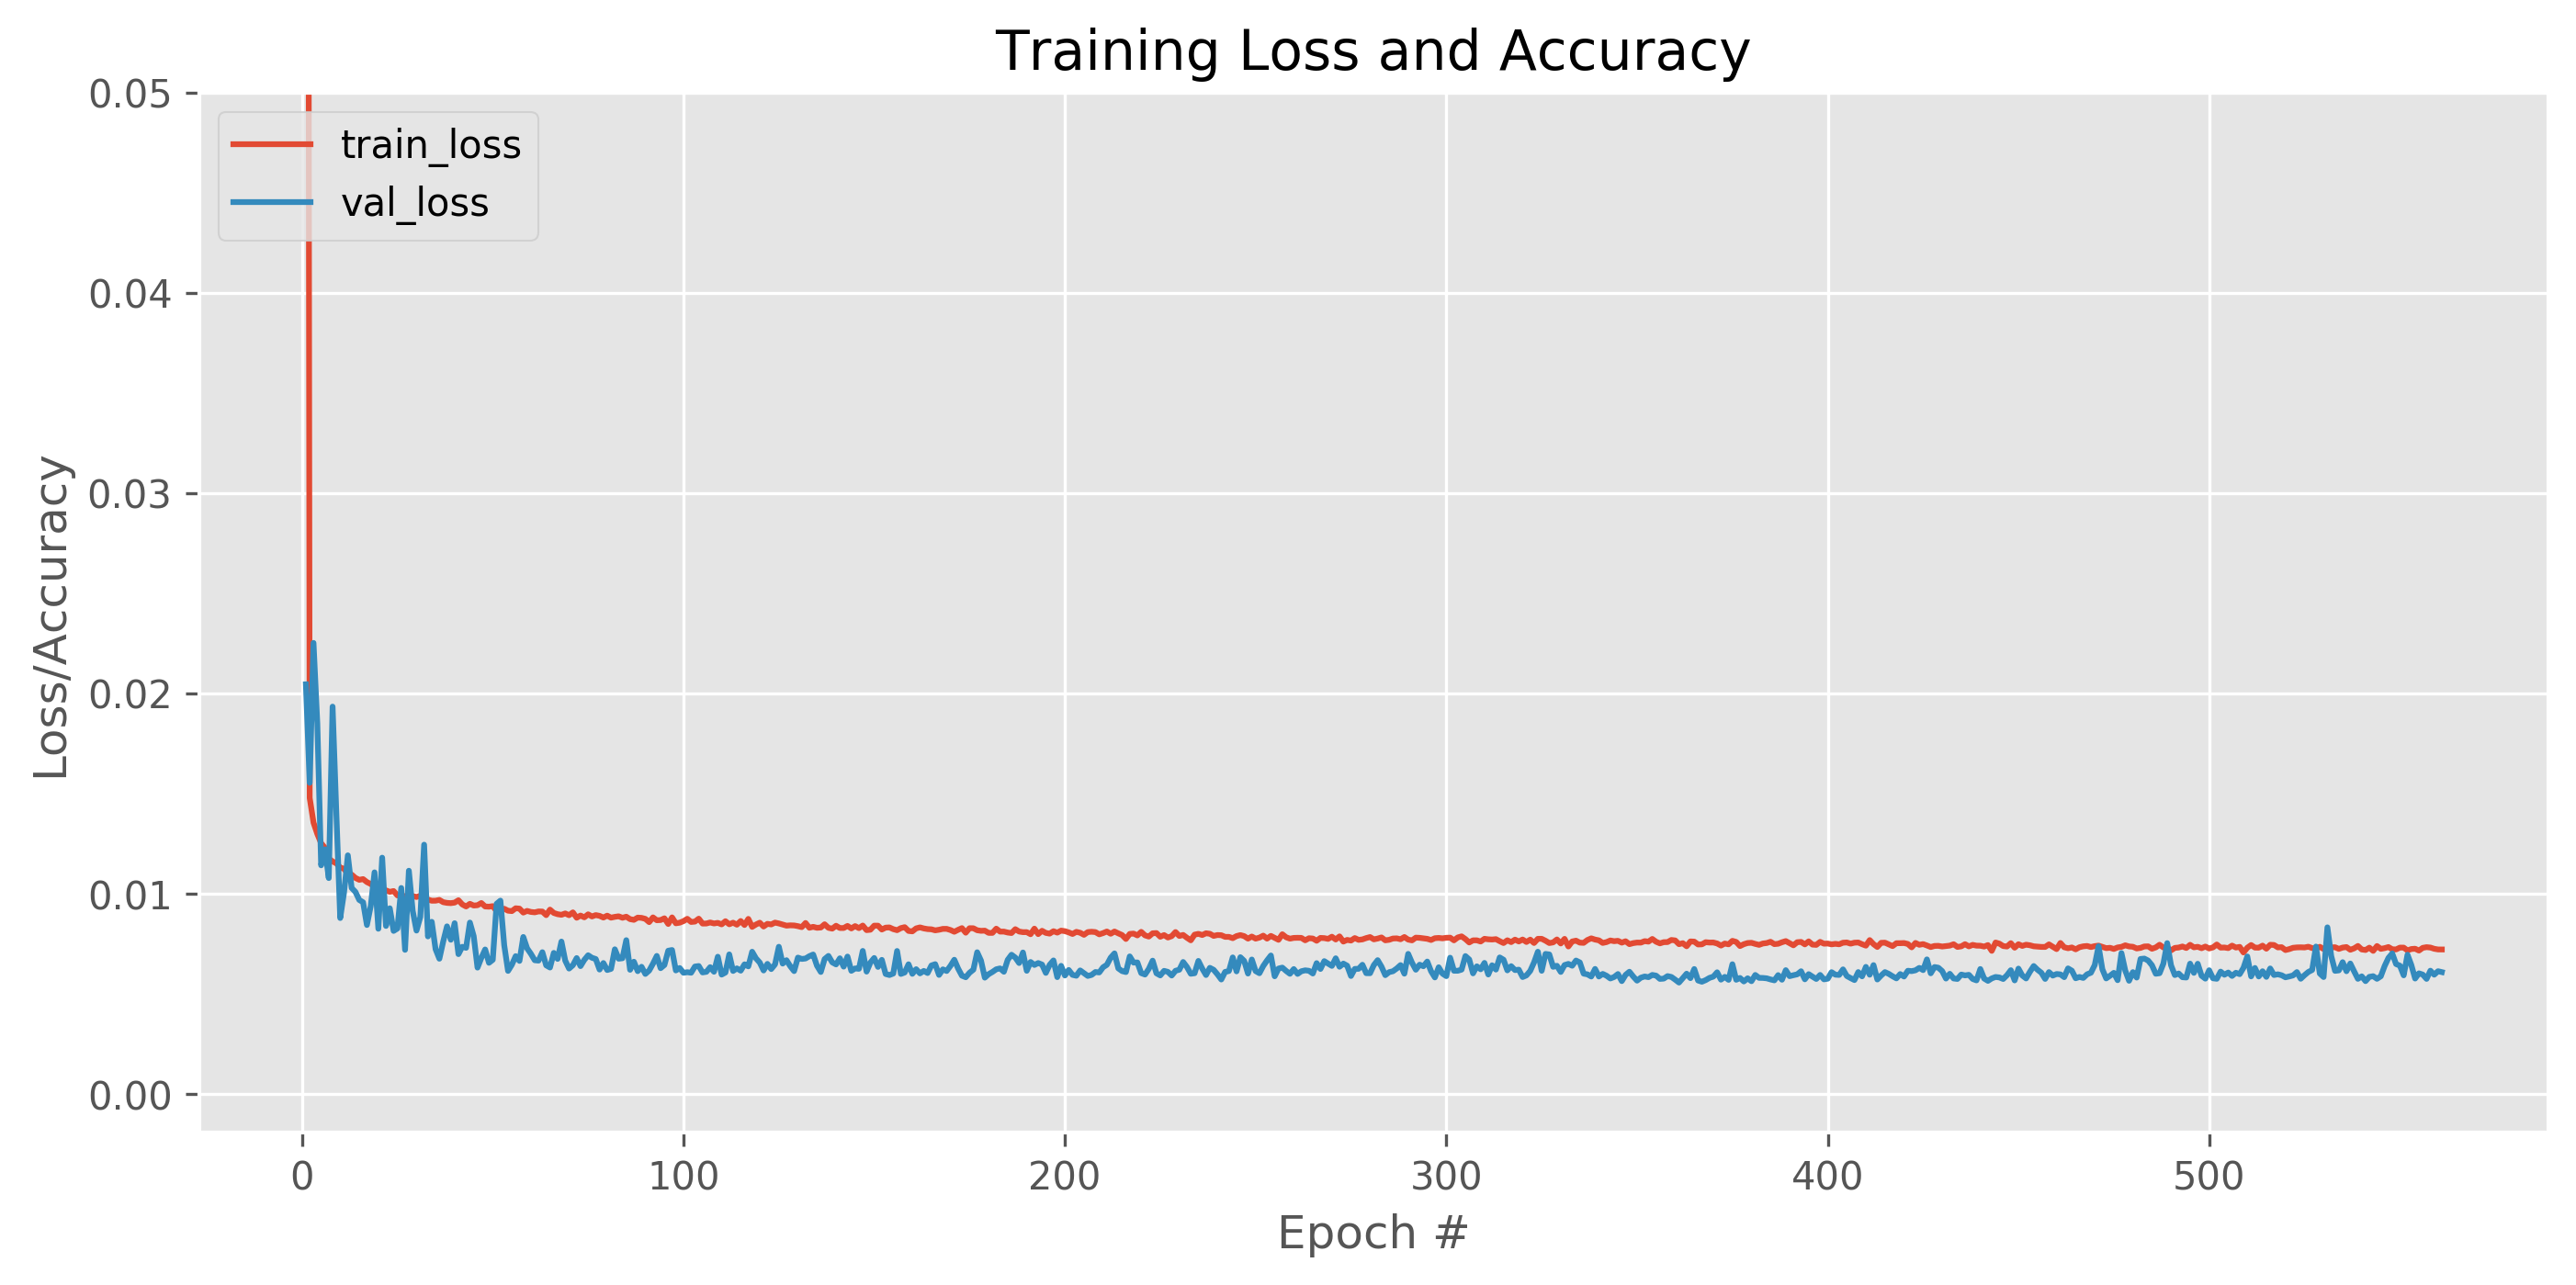

In [14]:
# plot the training loss

df_history = pd.read_csv('/data/'+ filename + "_loss.csv", index_col='epoch')

plt.style.use("ggplot")
fig = plt.figure(figsize=(11, 5), dpi=300)
plt.plot(df_history.index, df_history['train_loss'], label="train_loss")
plt.plot(df_history.index, df_history['val_loss'], label="val_loss")

plt.ylim(top=0.05)

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

plt.savefig(
    "/data/" + filename + ".pdf", bbox_inches="tight", pad_inches=0,
)
plt.savefig(
    "/data/" + filename + ".png", bbox_inches="tight", pad_inches=0,
)

In [15]:
if not predict_only:
    print("loss:    ", H.history["loss"][-1])
    print("val_loss:", H.history["val_loss"][-1])

In [16]:
if not predict_only:
    with h5py.File(path_model, "w") as file:
        weight = model.get_weights()
        for i in range(len(weight)):
            file.create_dataset("weight" + str(i), data=weight[i])

In [17]:
!ls -al {path_model}

-rw-r--r-- 1 root root 3520560 Jan 29 23:28 /data/input_noise.h5


In [18]:
with h5py.File(path_model,'r') as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
        
model.set_weights(weight)
# weight

In [19]:
def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [20]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [21]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
predictions = model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

predictions = [x[0] for x in predictions]
# predictions

W0130 03:30:12.984317 140151683143424 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 7500 batches). You may need to use the repeat() function when building your dataset.


In [22]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
for batch in iter:
    ids.extend(batch[1].numpy())

ids = [x.decode() for x in ids]
# ids

W0130 03:30:13.019509 140151683143424 deprecation.py:323] From <ipython-input-22-550982f305b6>:2: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [23]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

true_year = []
for batch in iter:
    true_year.extend(batch[2].numpy())

# true_year

In [24]:
df = pd.DataFrame(zip(ids, true_year, predictions), columns=['ID', 'true_year', 'prediction'])
# df

In [25]:
df.corr()

,true_year,prediction
true_year,1.000000,0.887621
prediction,0.887621,1.000000


In [26]:
corr_year = df['true_year'].corr(df['prediction'])
r2_text = format(corr_year**2, '.3f')
r2_text = '$r^2 = ' + r2_text + '$'

if predict_test_only: 
    r2_text += '\n(Test dataset only)'
    
r2_text

'$r^2 = 0.788$\n(Test dataset only)'

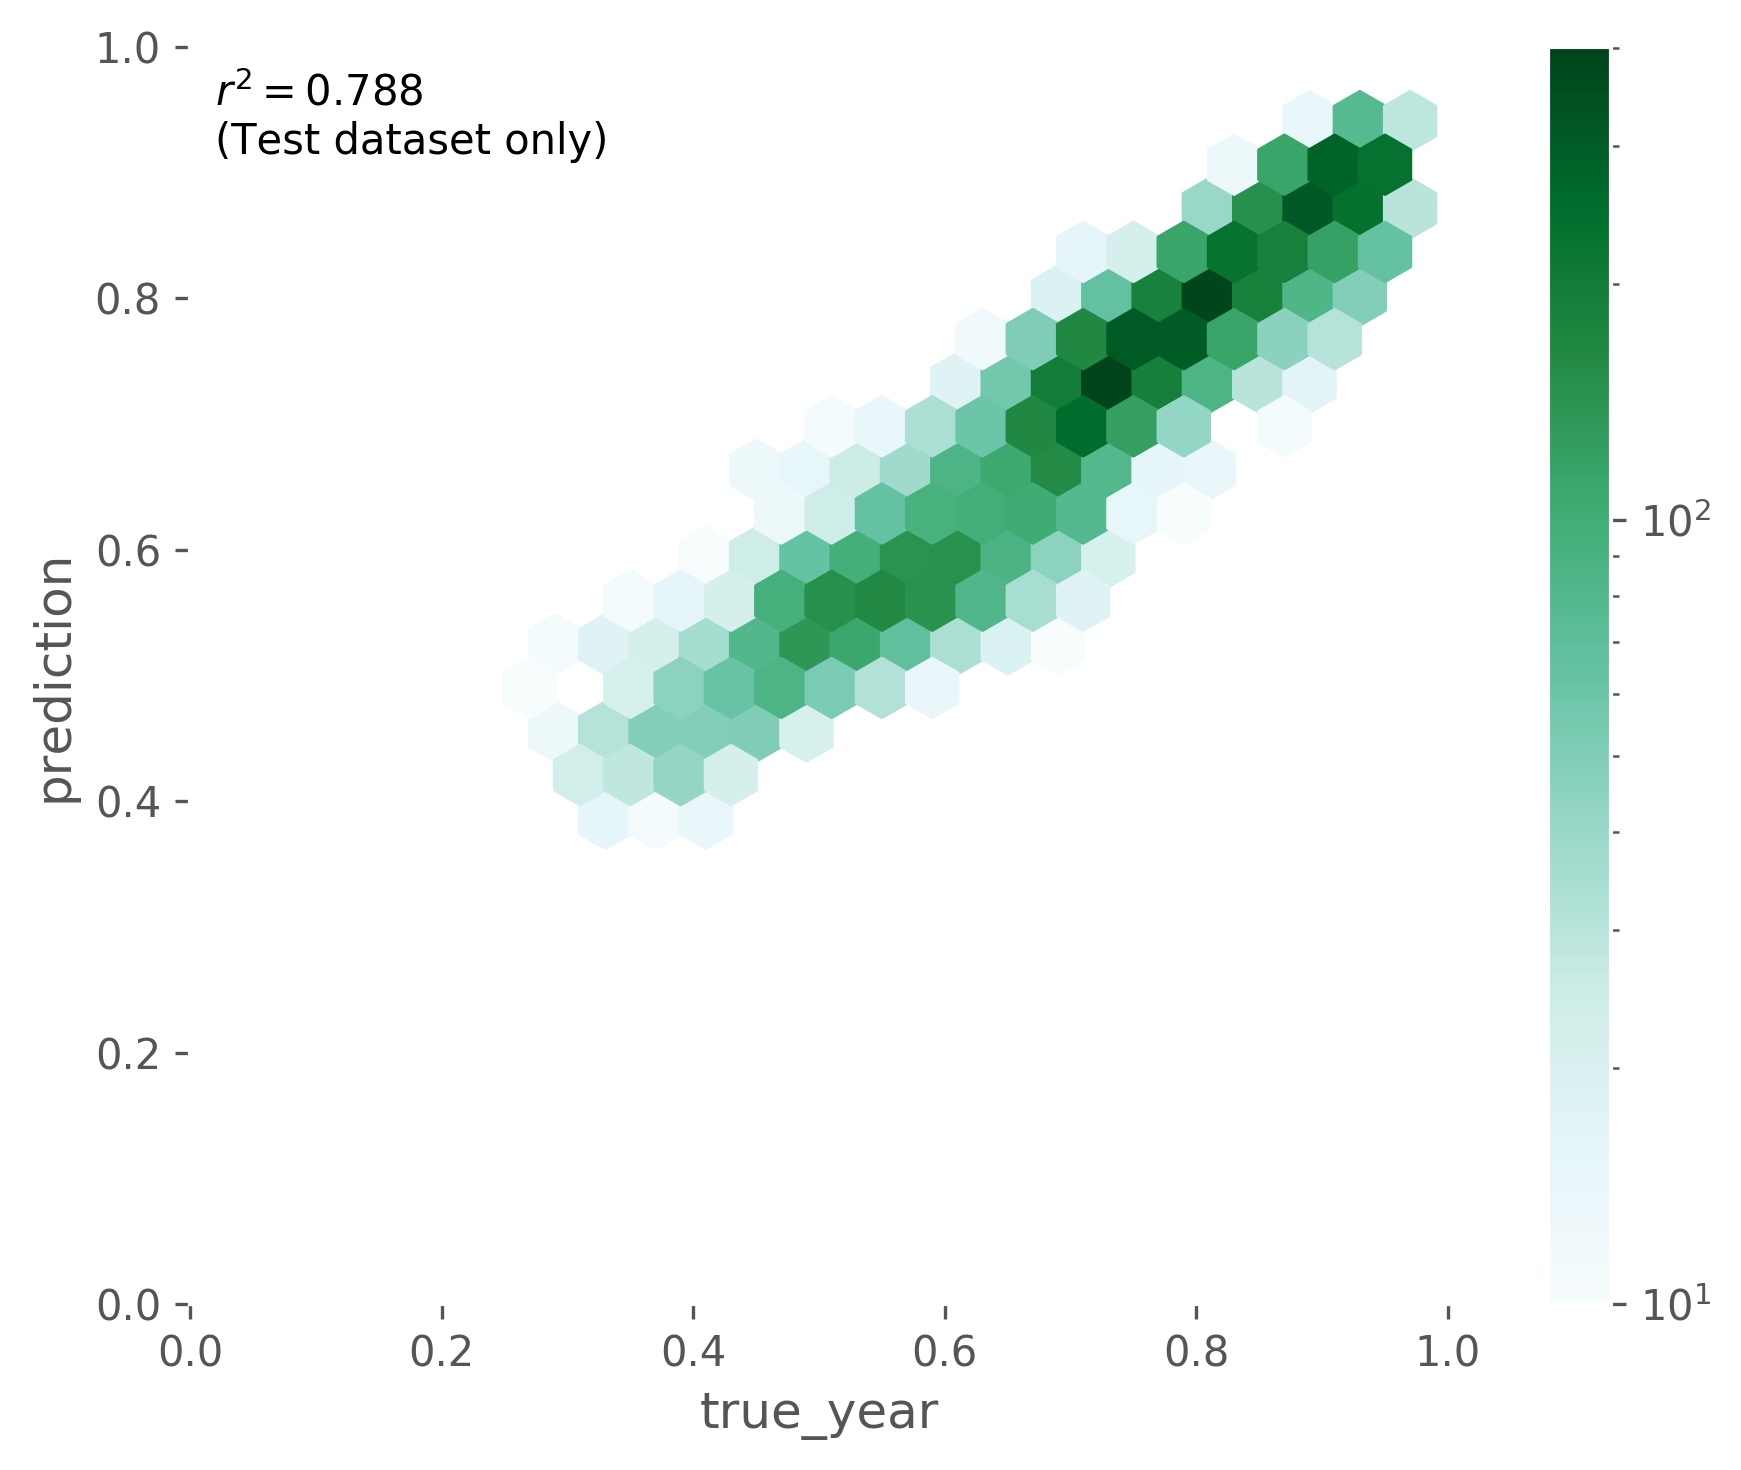

In [27]:
fig = plt.figure(figsize=(7, 5), dpi=300)
ax = fig.gca()

ax = df.plot.hexbin(
    x="true_year",
    y="prediction",
    extent=(-0.03, 1.01, -0.03, 1.01),
    xlim=(0, 1),
    ylim=(0, 1),
    sharex=False,
    gridsize=26,
    bins="log",
    mincnt=10,
    ax=ax,
)
ax.set_facecolor("w")
ax.set_aspect("equal")
ax.text(0.02, 0.98, r2_text, verticalalignment="top")

if predict_test_only:
    dataset_tag = "_testonly"
else:
    dataset_tag = ""

plt.tight_layout()


fig.savefig(
    "/data/" + filename + "_prediction" + dataset_tag + ".pdf",
    bbox_inches="tight",
    pad_inches=0,
)
fig.savefig(
    "/data/" + filename + "_prediction" + dataset_tag + ".png",
    bbox_inches="tight",
    pad_inches=0,
)

In [28]:
!cp /data/{filename}* .

In [29]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

layer_name = 'learned_representation'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
intermediate_output = intermediate_layer_model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

intermediate_output

W0130 03:30:20.047569 140151683143424 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps * epochs` batches (in this case, 7500 batches). You may need to use the repeat() function when building your dataset.


array([[ -541.635  ,  2304.3647 ,  -553.1716 , ...,  2508.3108 ,
         -606.9521 ,  1775.8513 ],
       [ 1049.1929 ,   853.929  ,   967.21356, ...,   890.89594,
         1037.4001 ,   326.94705],
       [ -414.0509 ,  2101.555  ,   870.85297, ...,  1781.5862 ,
          826.9898 ,  1594.1538 ],
       ...,
       [ -997.44183,  2299.974  , -1040.5581 , ...,  2660.547  ,
         -976.65356,  2003.4902 ],
       [  697.15594,   842.81256,   657.4956 , ...,  1849.3132 ,
          322.41104,  1056.6752 ],
       [ -835.7914 ,  2363.372  ,   678.5028 , ...,  1806.3074 ,
          791.27875,  1667.2485 ]], dtype=float32)

In [30]:
len(intermediate_output)

10185